# Parameter selection example - PICO

In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from parameter_selection_toolbox import *

# Settings

In [2]:
# Directories
figure_dir = 'figures'
data_path="/media/NAS2/ISMIP7/"
ensemble_path="/media/NAS2/pism_out/"

# Constants
yearlen = 365.14*24*60*60 # seconds per year
ice_density = 918 # kg/m3
reso=8000 # m model resolution used for melt parameterisation [m]


# parameterisation ensemble table 
p1_name = 'ocean.pico.overturning_coefficent'
p2_name = 'ocean.pico.heat_exchange_coefficent'

pism_present_day_ensemble = "pism_11_ismip7_picotest_zhou_initmip8km"
ensemble_table = pd.read_csv('./'+pism_present_day_ensemble+'.txt',
                                 sep=r'\s+',index_col=0)
#ensemble_table

# Load data

In [4]:
# Supporting Data

# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset(os.path.join(data_path,'share_with_modellers', 'imbie2', "basin_numbers_ismip8km.nc"))
basins = basins.rename({'basinNumber':'basins'})
nBasins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset(os.path.join(data_path,'share_with_modellers', 'meltmip','melt_paolo_err_adusumilli_ismip8km.nc')) # Field
MeltDataImbie = pd.read_csv(os.path.join(data_path,'share_with_modellers', 'meltmip','Melt_Paolo_Err_Adusumilli_imbie2.csv'), index_col=0) # Aggregated per imbier basin

# Buttressing Flux Response Numbers, remapped to 8km 
bfrn = xr.load_dataset(os.path.join(data_path,'share_with_modellers', 'meltmip',"BFRN_ismip8km.nc"))
nBins = 10

In [5]:
# Load ensembles

pism_present_day_ensemble = "pism_11_ismip7_picotest_zhou_initmip8km"
pism_mathiot_cold_ensemble = "pism_11_ismip7_picotest_Mathiot_cold_initmip8km"
pism_mathiot_warm_ensemble = "pism_11_ismip7_picotest_Mathiot_warm_initmip8km"

pd_ensemble = xr.load_dataset('Ensemble_'+pism_present_day_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_cold_ensemble = xr.load_dataset('Ensemble_'+pism_mathiot_cold_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_warm_ensemble = xr.load_dataset('Ensemble_'+pism_mathiot_warm_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])

In [6]:
bed = xr.load_dataset(os.path.join(data_path,'share_with_modellers', 'topography', 'bedmap3_ismip_8km.nc'))
mask = bed.floating_frac>0.5

# Optimise

In [7]:
sample_size=10000
min_p1, min_p2, min_coords = calculate_objective_function('all',sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path+"/share_with_modellers", 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

Sampling, this might take a moment...


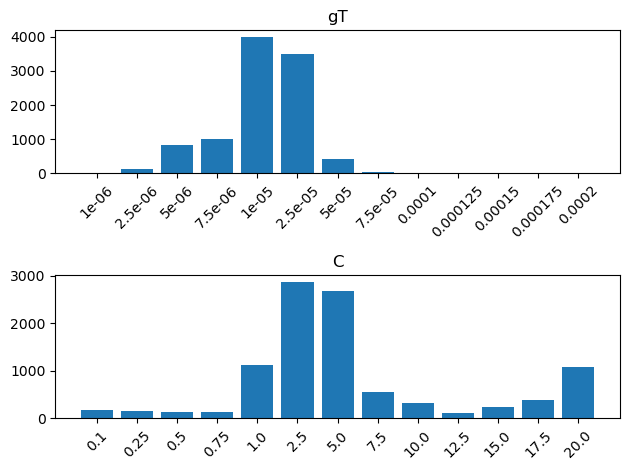

In [8]:
fig,axes = plt.subplots(2,1, sharex=False, sharey=False)
ax = axes.flatten()[0]

bin_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
counts, _ = np.histogram(np.array(min_p2), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]# [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('gT')

ax = axes.flatten()[1]
bin_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _ = np.histogram(np.array(min_p1)/1e6, bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6])/1e6  #[f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('C')
plt.tight_layout()

plt.savefig(os.path.join(figure_dir,pism_present_day_ensemble+'_Hists_Sample'+str(sample_size)+'.png'))

<Figure size 640x480 with 0 Axes>

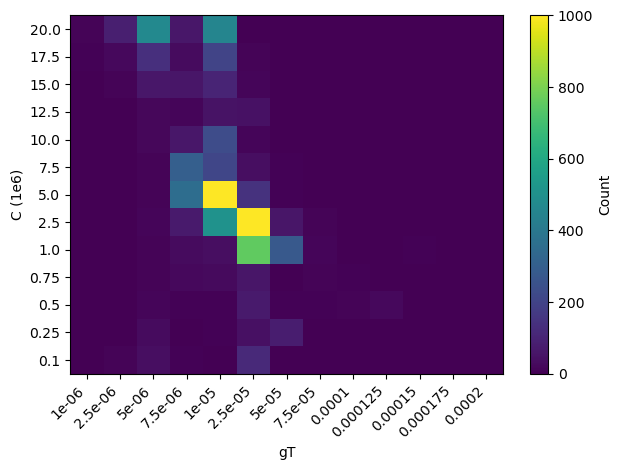

In [10]:
fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

x_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
y_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _, _ = np.histogram2d(min_p2,np.array(min_p1)/1e6, bins=[x_edges, y_edges])
plt.clf()

fig, ax = plt.subplots()

im = ax.pcolormesh(np.arange(len(x_edges)), np.arange(len(y_edges)), 
                    counts.T, cmap='viridis', shading='auto', vmin=0 , vmax=1000
                  )

y_labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6]) /1e6
x_labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]

# Set tick positions and labels
ax.set_xticks(np.arange(len(x_labels))+0.5)
ax.set_yticks(np.arange(len(y_labels))+0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.set_ylabel("C (1e6)")
ax.set_xlabel("gT")
plt.colorbar(im, label='Count')
plt.tight_layout()

plt.savefig(os.path.join(figure_dir,pism_present_day_ensemble+'_Hist2D_Sample'+str(sample_size)+'_all.png'))    

# Select parameters
It is not straightforward how to select the 5th and 95th percentile parameters from the PICO ensemble, a look into the sensitivity might help

In [12]:
# Median the most frequent value
C= 5e6
gT=1e-5

for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

Basin  1 : 1.07 m/a/K
Basin  2 : 2.04 m/a/K
Basin  3 : 2.52 m/a/K
Basin  4 : 2.4 m/a/K
Basin  5 : 3.81 m/a/K
Basin  6 : 2.76 m/a/K
Basin  7 : 3.08 m/a/K
Basin  8 : 3.97 m/a/K
Basin  9 : 3.94 m/a/K
Basin  10 : 3.9 m/a/K
Basin  11 : 3.76 m/a/K
Basin  12 : 0.91 m/a/K
Basin  13 : 3.44 m/a/K
Basin  14 : 3.18 m/a/K
Basin  15 : 3.39 m/a/K
Basin  16 : 3.04 m/a/K
Basin  17 : 4.18 m/a/K
Basin  18 : 2.62 m/a/K
Basin  19 : 3.47 m/a/K
Corresponding deltaT values: [-0.52 -0.38 -1.13 -1.67 -1.23 -0.58 -0.45 -0.25 -0.75 -1.   -0.02 -0.58
 -1.27  1.2  -2.   -2.    2.   -0.65 -0.58]


In [13]:
# For the 5th percentile, two values are possible, either small(est) C and corresponding gammaT, or other way around
# Given the different sensitivities in different basins, it might be worth trying both
C= 0.1e6
gT=2.5e-5
for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

C= 5e6
gT=0.5e-5
for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

Basin  1 : 0.11 m/a/K
Basin  2 : 0.5 m/a/K
Basin  3 : 0.75 m/a/K
Basin  4 : 0.8 m/a/K
Basin  5 : 4.45 m/a/K
Basin  6 : 0.57 m/a/K
Basin  7 : 1.78 m/a/K
Basin  8 : 5.31 m/a/K
Basin  9 : 5.25 m/a/K
Basin  10 : 4.93 m/a/K
Basin  11 : 4.77 m/a/K
Basin  12 : 0.11 m/a/K
Basin  13 : 2.41 m/a/K
Basin  14 : 5.17 m/a/K
Basin  15 : 2.03 m/a/K
Basin  16 : 1.36 m/a/K
Basin  17 : 9.71 m/a/K
Basin  18 : 0.82 m/a/K
Basin  19 : 3.03 m/a/K
Corresponding deltaT values: [ 2.    0.83  0.3  -0.83 -1.17  1.2   0.35 -0.   -0.63 -0.85  0.08  2.
 -0.05  1.52 -1.4   0.23  0.7   0.4  -0.25]
Basin  1 : 0.77 m/a/K
Basin  2 : 1.29 m/a/K
Basin  3 : 1.51 m/a/K
Basin  4 : 1.46 m/a/K
Basin  5 : 1.99 m/a/K
Basin  6 : 1.61 m/a/K
Basin  7 : 1.73 m/a/K
Basin  8 : 1.78 m/a/K
Basin  9 : 2.03 m/a/K
Basin  10 : 2.02 m/a/K
Basin  11 : 1.96 m/a/K
Basin  12 : 0.69 m/a/K
Basin  13 : 1.87 m/a/K
Basin  14 : 2.03 m/a/K
Basin  15 : 1.81 m/a/K
Basin  16 : 1.71 m/a/K
Basin  17 : 2.09 m/a/K
Basin  18 : 1.56 m/a/K
Basin  19 : 1.87 m/a/K
Co

In [14]:
# For the 95th percentile, two values are possible, either larg(est) C and corresponding gammaT, or other way around
# Given the different sensitivities in different basins, I would suggest trying both. Or focusig on the relevant regions
# or chose the parameters that yield highest sensitivity in the corresponding region
C= 20e6
gT=1e-5
for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')
print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

# For the 95th percentile, two values are possible, either larg(est) C and corresponding gammaT, or other way around
C= 0.5e6
gT=12.5e-5
for basin in range(1,20): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=C,p2=gT,basin=basin).values,2), 'm/a/K')
print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=C,p2=gT).values)

Basin  1 : 1.97 m/a/K
Basin  2 : 2.78 m/a/K
Basin  3 : 3.18 m/a/K
Basin  4 : 2.99 m/a/K
Basin  5 : 3.97 m/a/K
Basin  6 : 3.38 m/a/K
Basin  7 : 3.55 m/a/K
Basin  8 : 4.08 m/a/K
Basin  9 : 4.07 m/a/K
Basin  10 : 4.04 m/a/K
Basin  11 : 3.96 m/a/K
Basin  12 : 1.68 m/a/K
Basin  13 : 3.79 m/a/K
Basin  14 : 4.09 m/a/K
Basin  15 : 3.78 m/a/K
Basin  16 : 3.59 m/a/K
Basin  17 : 4.19 m/a/K
Basin  18 : 3.27 m/a/K
Basin  19 : 3.79 m/a/K
Corresponding deltaT values: [-0.63 -0.48 -1.25 -1.75 -1.25 -0.67 -0.58 -0.35 -0.77 -1.02 -0.05 -0.7
 -1.45  0.98 -2.   -2.    2.   -0.75 -0.65]
Basin  1 : 0.54 m/a/K
Basin  2 : 1.57 m/a/K
Basin  3 : 2.28 m/a/K
Basin  4 : 2.62 m/a/K
Basin  5 : 17.17 m/a/K
Basin  6 : 2.51 m/a/K
Basin  7 : 6.22 m/a/K
Basin  8 : 20.19 m/a/K
Basin  9 : 20.94 m/a/K
Basin  10 : 20.07 m/a/K
Basin  11 : 18.7 m/a/K
Basin  12 : 0.35 m/a/K
Basin  13 : 7.85 m/a/K
Basin  14 : 18.37 m/a/K
Basin  15 : 8.5 m/a/K
Basin  16 : 3.97 m/a/K
Basin  17 : 45.66 m/a/K
Basin  18 : 2.73 m/a/K
Basin  19 : 11.51

Sampling, this might take a moment...


<Figure size 640x480 with 0 Axes>

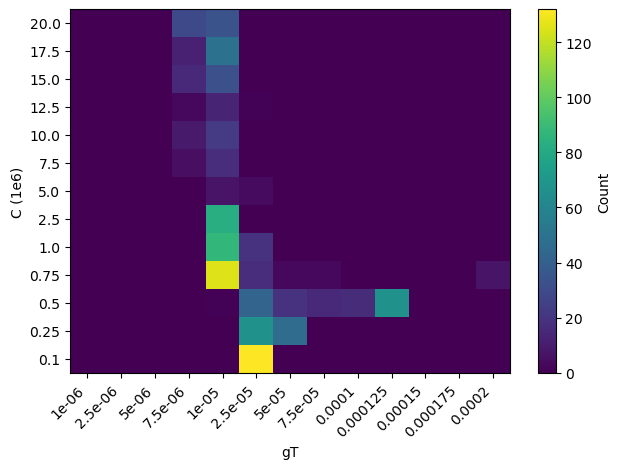

In [15]:
sample_size=1000
min_p1, min_p2, min_coords = calculate_objective_function('term1',sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path+"/share_with_modellers", 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

x_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
y_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _, _ = np.histogram2d(min_p2,np.array(min_p1)/1e6, bins=[x_edges, y_edges])
plt.clf()

fig, ax = plt.subplots()

im = ax.pcolormesh(np.arange(len(x_edges)), np.arange(len(y_edges)), 
                    counts.T, cmap='viridis', shading='auto', vmin=0 
                  )

y_labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6]) /1e6
x_labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]

# Set tick positions and labels
ax.set_xticks(np.arange(len(x_labels))+0.5)
ax.set_yticks(np.arange(len(y_labels))+0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.set_ylabel("C (1e6)")
ax.set_xlabel("gT")
plt.colorbar(im, label='Count')
plt.tight_layout()

plt.savefig(os.path.join(figure_dir,pism_present_day_ensemble+'_Hist2D_Sample'+str(sample_size)+'_Term1.png'))    

Sampling, this might take a moment...


<Figure size 640x480 with 0 Axes>

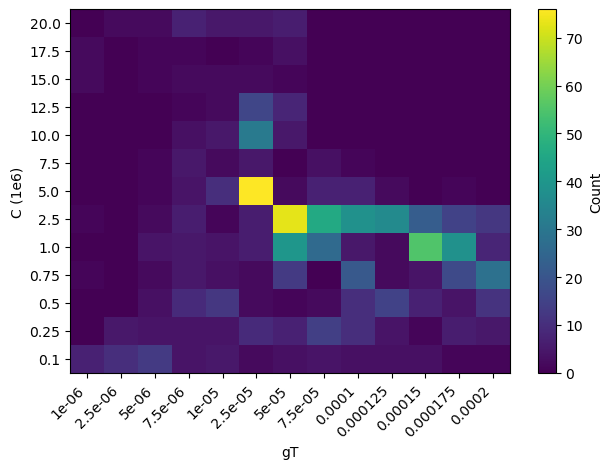

In [34]:
sample_size=1000
min_p1, min_p2, min_coords = calculate_objective_function('term2',sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path+"/share_with_modellers", 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

x_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
y_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _, _ = np.histogram2d(min_p2,np.array(min_p1)/1e6, bins=[x_edges, y_edges])
plt.clf()

fig, ax = plt.subplots()

im = ax.pcolormesh(np.arange(len(x_edges)), np.arange(len(y_edges)), 
                    counts.T, cmap='viridis', shading='auto', vmin=0 
                  )

y_labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6]) /1e6
x_labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]

# Set tick positions and labels
ax.set_xticks(np.arange(len(x_labels))+0.5)
ax.set_yticks(np.arange(len(y_labels))+0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.set_ylabel("C (1e6)")
ax.set_xlabel("gT")
plt.colorbar(im, label='Count')
plt.tight_layout()

plt.savefig(os.path.join(figure_dir,pism_present_day_ensemble+'_Hist2D_Sample'+str(sample_size)+'_Term2.png'))       

Sampling, this might take a moment...


<Figure size 640x480 with 0 Axes>

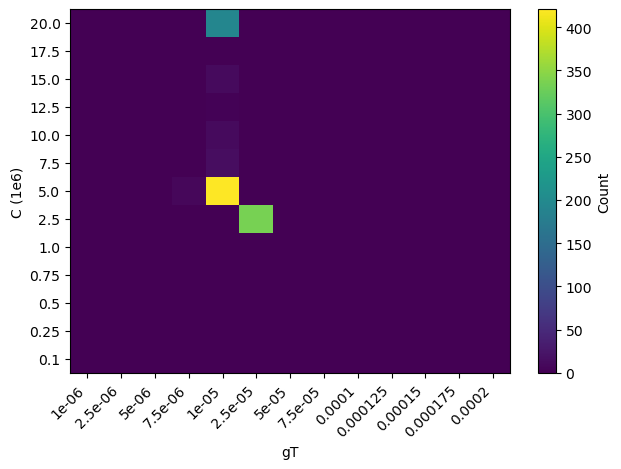

In [35]:
sample_size=1000
min_p1, min_p2, min_coords = calculate_objective_function('term3',sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path+"/share_with_modellers", 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

x_edges = np.array( [0.01e-5,0.15e-5,0.3e-5,0.6e-5,0.8e-5,1.1e-5,3e-5,6e-5,8e-5,11e-5,13e-5,16e-5,18e-5,21e-5])
y_edges = np.array( [0.001e6,0.2e6, 0.3e6, 0.6e6, 0.8e6 ,1.1e6 ,3e6, 6e6, 8e6, 11e6, 13e6, 16e6, 18e6, 21e6]) /1e6
counts, _, _ = np.histogram2d(min_p2,np.array(min_p1)/1e6, bins=[x_edges, y_edges])
plt.clf()

fig, ax = plt.subplots()

im = ax.pcolormesh(np.arange(len(x_edges)), np.arange(len(y_edges)), 
                    counts.T, cmap='viridis', shading='auto', vmin=0
                  )

y_labels = np.array([0.1e6, 0.25e6, 0.5e6, 0.75e6 ,1.0e6 ,2.5e6, 5.0e6, 7.5e6, 10.0e6, 12.5e6, 15e6, 17.5e6, 20e6]) /1e6
x_labels = [0.1e-5,0.25e-5,0.5e-5,0.75e-5,1e-5,2.5e-5,5e-5,7.5e-5,10e-5,12.5e-5,15e-5,17.5e-5,20e-5]

# Set tick positions and labels
ax.set_xticks(np.arange(len(x_labels))+0.5)
ax.set_yticks(np.arange(len(y_labels))+0.5)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticklabels(y_labels)

ax.set_ylabel("C (1e6)")
ax.set_xlabel("gT")
plt.colorbar(im, label='Count')
plt.tight_layout()

plt.savefig(os.path.join(figure_dir,pism_present_day_ensemble+'_Hist2D_Sample'+str(sample_size)+'_Term3.png'))    